# Data Wrangling & EDA for Hemingway Next Word Prediction

## Introduction

Using *The Sun Also Rises* by Ernest Hemingway, this project will craft a next word prediction NLP object using Google's BERT. The wonderful venture Project Guttenberg (https://www.gutenberg.org/) provides free texts in electronic format. The text for this effort was chosen from Project Guttenberg and cleaned of its leading matter and liscence information.

## Table of Contents <a id="id0"></a>

1. [Import Packages](#id1)
2. [Load the Data](#id2)
3. [First Look Inside](#id3)
4. [Using spaCy for Initial Assessment](#id4)
5. [Frequency Counts for Nouns, Verbs, and Adjectives](#id5)
6. [Sentence Frequency by Word Count](#id6)
7. [Ngram Exploration](#id7)
8. [Saving the Data](#id7)

<a id="id1"></a>

[Back to the TOC](#id0)


## Import Packages <a id="id1"></a>

In [380]:
import pandas as pd
import spacy
import spacy_cleaner
from spacy_cleaner.processing import removers, replacers, mutators
from spacy.matcher import Matcher
from nltk import bigrams
from nltk.tokenize import RegexpTokenizer
import nltk, re, string, collections
from nltk.lm import NgramCounter
from nltk.util import ngrams
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import seaborn as sns

[Back to the TOC](#id0)


## Load the Data <a id="id2"></a>

The novel *The Sun Also Rises* by Ernest Hemingway can be found at Project Gutenberg here: https://www.gutenberg.org/ebooks/67138 . 

In [6]:
### The Project Gutenberg information and publisher copyright information was removed manually with a text processing program.
dataset = open("Sun_Also_Rises.txt", "r").read()
# Loading the dataset
path = 'Sun_Also_Rises.txt'
text = open(path).read().lower()

print('The text has {:,} separate items'.format(len(text)))


The text has 364,517 separate items


[Back to the TOC](#id0)


<a id="id3"></a>
## First Look Inside

In [7]:
## Creating a Word Cloud function from unprocessed text of Sun Also Rises
def create_word_cloud(string):
   cloud = WordCloud(background_color = "white", max_words = 100,  stopwords = set(STOPWORDS))
   cloud.generate(string)
   cloud.to_file("wordCloud.png")
###Quick setup of the tokenizer from nltk
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

a= ' '.join(words) 

In [8]:
create_word_cloud(a)
##And creating a 2nd one with just 100 max_words which reads more cleanly

In [10]:
## it looks like there are a lot of "s" hanging out by themselves, most likely the posessive 's' separated from removing and then spacing.
#How many of them as "words"? Same for free 't' of don't
def count_S(string):
    S_count = 0
    for item in (string):
        if item == "s":
            S_count += 1
    return S_count
s = count_S(a)
print("The count of free possesive Ses is {:,}".format(s))

def count_T(string):
    T_count = 0
    for item in (string):
        if item == "t":
            T_count += 1
    return T_count
t = count_T(a)
print("The count of free Tes is {:,}".format(t))

The count of free possesive Ses is 15,155
The count of free Tes is 26,404


[Back to the TOC](#id0)


## Using spaCy for Initial Assessment  <a id="id4"></a>

In [12]:
##Using spaCy to build an nlp pipeline
# Create a blank English nlp object
nlp = spacy.blank("en")

In [13]:
##checking to see if processing pipeline is up and running
doc = nlp("Hello world!")

# Iterate over tokens in a Doc
for token in doc:
    print(token.text)

Hello
world
!


In [14]:
#SAR will be the fullest text for "The Sun Also Rises"
SAR = nlp(text)
## Checking a random token from SAR
token2 = SAR[47]
span = SAR[147:156]
print(token2)
print(span)

sun
middleweight boxing champion of princeton. do not



In [15]:
### How much punctuation is there?
print("How many tokens are punctuation? {:,}".format(sum([token.is_punct for token in SAR])))

How many tokens are punctuation? 19,371


In [16]:
### How much numbers are there?
print("How many tokens are numbers? {:,}".format(sum([token.like_num for token in SAR])))

How many tokens are numbers? 748


In [17]:
### How much text-based words are there?
print("How many tokens are text words? {:,}".format(sum([token.is_alpha for token in SAR])))

How many tokens are text words? 68,315


In [18]:
### Working with their English pipeline (small)
nlp = spacy.load("en_core_web_sm")
nlp

In [19]:
SAR = nlp(text)

In [20]:
### A quick check of how the pos parser is doing
span = SAR[100:125]
for token in span:
    print(token.text, token.pos_)

rivers NOUN
run VERB
into ADP

     SPACE
the DET
sea NOUN
; PUNCT
yet CCONJ
the DET
sea NOUN
is AUX
not PART
full ADJ
; PUNCT
unto ADP
the DET
place NOUN
from ADP
whence ADV
the DET

     SPACE
rivers NOUN
come VERB
, PUNCT
thither PROPN


In [23]:
### looking at a few NER instances
for token in SAR.ents[100:125]:
    print(token.text, token.label_)
### dates, times, gpes, persons, org, and cardinal numbers seem to work well

the quarter DATE
the quarter DATE
one night TIME
night TIME
paris GPE
two CARDINAL
south america LOC
paris GPE
first ORDINAL
second ORDINAL
two hours TIME
robert PERSON
all last night TIME
3 CARDINAL
spring night TIME
robert PERSON
first ORDINAL
one CARDINAL
un ORG
paris GPE
the avenue de l’opéra ORG
new york GPE
the hour TIME
america GPE
the rue de rivoli ORG


In [33]:
### Let's get a clean version of the text with stop words and replacing punctuation;
### Perhaps lemmatization at a later stage but might need full forms for Next Word Prediction
### https://ce11an.github.io/spacy-cleaner/#example 

pipeline = spacy_cleaner.Pipeline(
    nlp, removers.remove_stopword_token)

In [34]:
SAR_clean = pipeline.clean(text)

Cleaning Progress: 100%|█████████████████████████████████████████████████████████| 364517/364517 [01:46<00:00, 3417.44it/s]


In [40]:
SAR[920:1000]



by that time, though, he had other things to worry about. he had been
taken in hand by a lady who hoped to rise with the magazine. she was
very forceful, and cohn never had a chance of not being taken in hand.
also he was sure that he loved her. when this lady saw that the magazine
was not going to rise, she became a little

In [41]:
SAR_clean[920:1000]
### So the problem here is that the "stopwords" removed "i" from the text, 
### and "a", even when they were part of other words?

['t',
 'h',
 '',
 't',
 '',
 '',
 's',
 '',
 '',
 '',
 'b',
 'o',
 'x',
 '',
 'n',
 'g',
 '',
 't',
 '',
 't',
 'l',
 'e',
 ',',
 '',
 'b',
 'u',
 't',
 '',
 '',
 't',
 '',
 'm',
 'e',
 '',
 'n',
 't',
 '',
 '',
 '',
 'l',
 'o',
 't',
 '',
 't',
 'o',
 '',
 'c',
 'o',
 'h',
 'n',
 '.',
 '',
 'h',
 'e',
 '',
 'c',
 '',
 'r',
 'e',
 'd',
 '',
 'n',
 'o',
 't',
 'h',
 '',
 'n',
 'g',
 '',
 'f',
 'o',
 'r',
 '',
 'b',
 'o',
 'x',
 '',
 'n',
 'g',
 ',']

In [48]:
### Working with Matcher to find
matcher = Matcher(SAR.vocab)
pattern = [{"POS": "ADJ"}, {"TEXT": "men"}]
matcher.add("Adj_PATTERN", [pattern])
matches = matcher(SAR)

In [49]:
for match_id, start, end in matches:
    # Get the matched span
    matched_span = SAR[start:end]
    print(matched_span.text)

young men
young men
several men
more men
other men


In [50]:
### Doing the same for "women"
### Working with Matcher to find
matcher = Matcher(SAR.vocab)
pattern = [{"POS": "ADJ"}, {"TEXT": "women"}]
matcher.add("Adj_PATTERN", [pattern])
matches = matcher(SAR)

In [51]:
for match_id, start, end in matches:
    # Get the matched span
    matched_span = SAR[start:end]
    print(matched_span.text)

several women
american women


 Not a lot of adjective description in general here. Let's get a look at just ADJ + NOUN combos.

In [54]:
### Doing the same for "women"
### Working with Matcher to find
matcher = Matcher(SAR.vocab)
pattern = [{"POS": "ADJ"}, {"POS": "NOUN"}]
matcher.add("Adj_Noun", [pattern])
matches = matcher(SAR)

In [90]:
for match_id, start, end in matches:
    # Get the matched span
    matched_span = SAR[start:end]
    print(matched_span.text)

lost generation
middleweight boxing
inner comfort
nice boy
young gentlemen
certain satisfaction
strange sort
last year
middleweight boxing
simple people
jewish families
military school
good end
nice boy
friendly boy
unattractive mould
domestic unhappiness
rich wife
healthful shock
literary people
short time
editorial page
sole editor
other things
literary friend
second year
careless possession
many people
bad novel
poor novel
local gymnasium
good walk
swell girl
american girl
good place
grand cerf
good publisher
awful row
several women
rotten time
first wife
attractive quantity
divine miracle
higher stakes
steep bridge
several times
innocent occupation
purple land
purple land
sinister book
amorous adventures
english gentleman
romantic land
french convent
complete set
practical alger
purple land
exalted connections
more fun
abnormal life
great trip
black princesses
stubborn streak
best way
good place
good town
first idea
outer room
big manila
other room
rotten dream
last night
rotten ha

In [92]:
### Word length average for the SAR. Overall, quite short
print(sum(len(token) for token in SAR)/len(SAR))

3.1410961030895823


[Back to the TOC](#id0)

<a id="id5"></a>
## Frequency Counts for Nouns, Verbs, and Adjectives

In [94]:
### drawing from this TDS site: https://towardsdatascience.com/lovecraft-with-natural-language-processing-part-2-tokenisation-and-word-counts-f970f6ff5690
### Will use lemmatization here to get unified counts
def create_word_counts_by_pos(text, list_of_pos, word_count_dict_input = None):
    """
    takes a raw text file
    tokenizes and lemmatizes it
    limits inspection to list_of_pos types of words
    counts the individual lemmas
    returns a dictionary, keys are POSes in list_of_pos
    values are dictinaries with word counts
    """
    doc = nlp(text)
    
    if word_count_dict_input is None: 
        word_count_dict = {}
        for part_of_speech in list_of_pos:
            word_count_dict[part_of_speech] = {}
    else:
        word_count_dict = word_count_dict_input

    for token in doc: 
        part_of_speech = token.pos_

        if part_of_speech in list_of_pos:
            word_lemma = token.lemma_
            current_count = word_count_dict[part_of_speech].get(word_lemma, 0)
            current_count += 1
            word_count_dict[part_of_speech][word_lemma] = current_count

    return word_count_dict

def filter_word_count_dict_to_frequent(word_count_dict, threshold):
    """
    Loops through word_count_dict, only keeps items where 
    value is higher than a certain threshold
    """
    frequent_word_count_dict = {}

    list_of_pos = word_count_dict.keys()

    for part_of_speech in list_of_pos:
        frequent_word_count_dict[part_of_speech] = {}
        for key in word_count_dict[part_of_speech]:
            if word_count_dict[part_of_speech][key] > threshold:
                frequent_word_count_dict[part_of_speech][key] = \
                word_count_dict[part_of_speech][key]
                
    return frequent_word_count_dict

def collect_most_frequent_words(word_count_dict, number_to_collect):
    """
    word_count_dict is assumed to be in a format where keys are part-of-speech, 
    values are counts
    number_of_collect: we will collect this amount from each group
    if there is a tie: the one that appeared first
    """

    list_of_pos = word_count_dict.keys()
    most_frequent_words = {}

    for part_of_speech in list_of_pos:
        most_frequent_words[part_of_speech] = \
        sorted(word_count_dict[part_of_speech].items(), \
            key=lambda x: x[1], reverse = True)[:number_to_collect] 
        
    return most_frequent_words


In [180]:
list_of_pos = ['NOUN']

In [181]:
word_count_dict = create_word_counts_by_pos(text, list_of_pos)


In [182]:
frequent_word_count_dict = filter_word_count_dict_to_frequent(word_count_dict, 10)

In [183]:
nouns_df = pd.DataFrame.from_dict(frequent_word_count_dict)
nouns_df.head()

,NOUN
_,15
afternoon,13
arcade,18
arm,36
ass,13


In [105]:
### DOING THE SAME THE for verbs; Will assess data frames together
list_of_pos = ['VERB']

In [106]:
word_count_dict = create_word_counts_by_pos(text, list_of_pos)


In [107]:
frequent_word_count_dict = filter_word_count_dict_to_frequent(word_count_dict, 10)

In [109]:
verbs_df = pd.DataFrame.from_dict(frequent_word_count_dict)
verbs_df.head()

,VERB
ask,175
be,185
become,15
behave,11
believe,21


In [110]:
### DOING THE SAME THE for verbs; Will assess data frames together
list_of_pos = ['ADJ']

In [111]:
word_count_dict = create_word_counts_by_pos(text, list_of_pos)


In [112]:
frequent_word_count_dict = filter_word_count_dict_to_frequent(word_count_dict, 10)

In [116]:
adjs_df = pd.DataFrame.from_dict(frequent_word_count_dict)
adjs_df.head()

,ADJ
asleep,12
awful,13
bad,47
beautiful,12
big,77


In [172]:
print(nouns_df.shape, verbs_df.shape, adjs_df.shape)

(222, 2) (146, 2) (80, 2)


In [171]:
adjs_df.reset_index(inplace=True)

verbs_df.reset_index(inplace=True)

In [155]:
adjs_df.rename(columns={'index':'ADJ'}, inplace=True)
#adjs_df.columns
#adjs_df.drop(columns=['level_0'], inplace=True)
adjs_df.sort_values('count', ascending=False).head()

,ADJ,count
28,good,228
40,little,107
53,other,82
4,big,77
38,jake,74


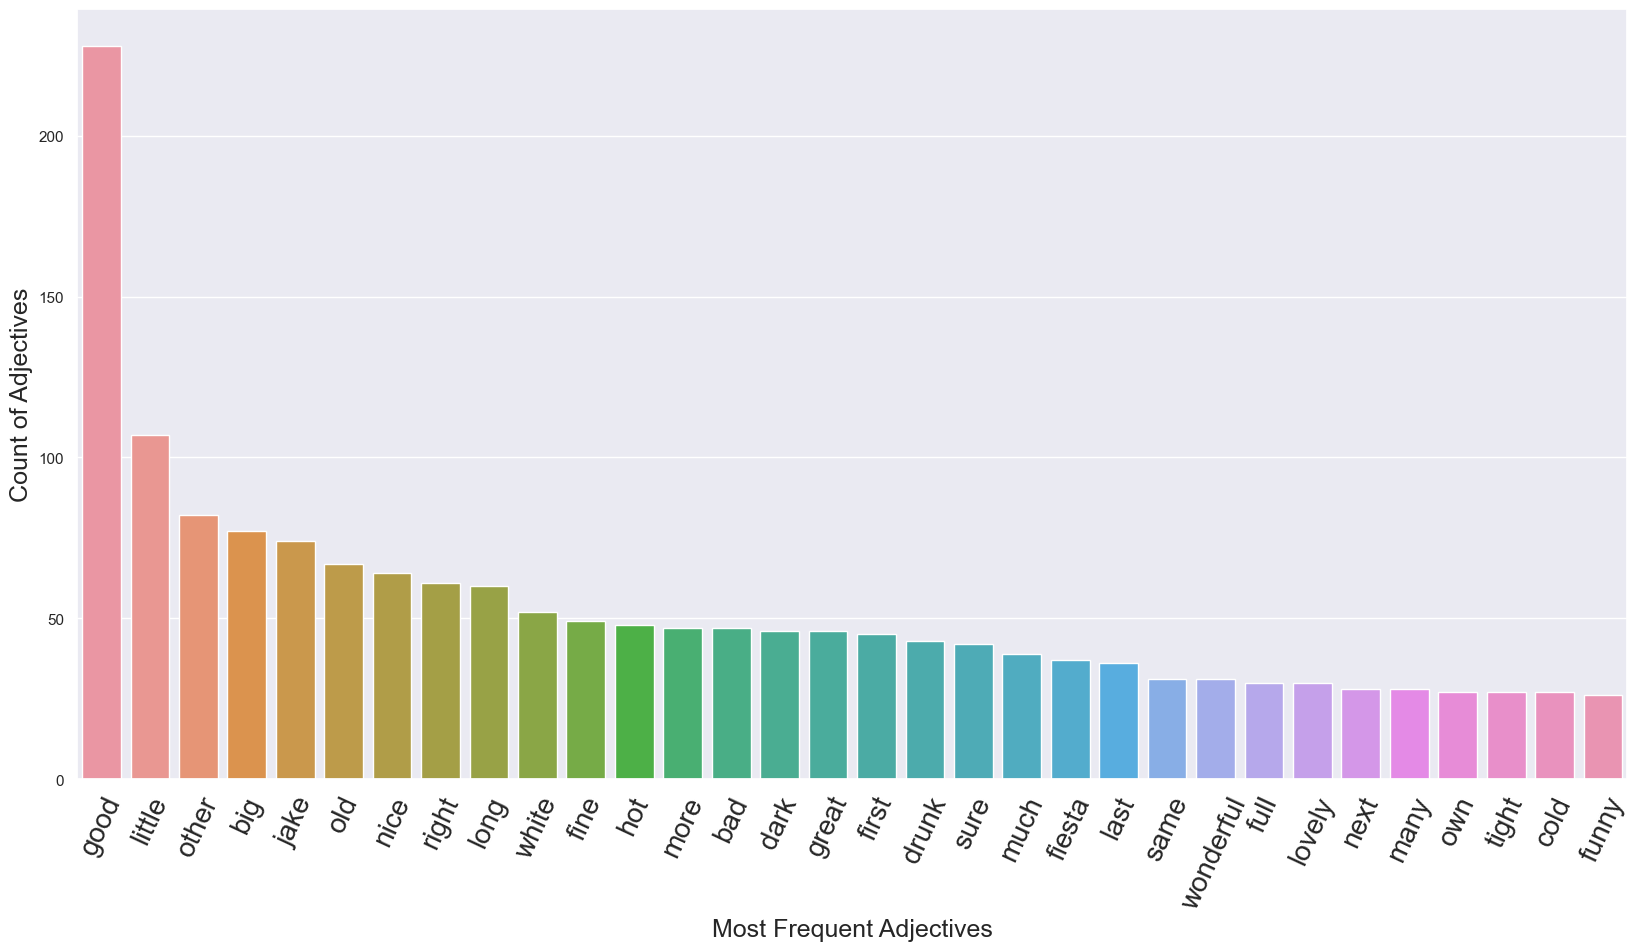

In [225]:
sns.barplot(x="ADJ", y='count', data=adjs_df.query('count > 25').sort_values('count', ascending=False))
sns.set(rc = {'figure.figsize':(20,10)})
plt.xlabel('Most Frequent Adjectives', fontsize=18)
plt.ylabel('Count of Adjectives', fontsize=18)
plt.xticks(rotation = 65, fontsize=20)
plt.savefig('Count for Frequent Adjectives')
plt.show()


In [190]:
#nouns_df.reset_index(inplace=True)
nouns_df.drop(columns='level_0', inplace=True)
nouns_df.head()

,index,NOUN
0,_,15
1,afternoon,13
2,arcade,18
3,arm,36
4,ass,13


In [229]:
#nouns_df.rename(columns={'NOUN':'count', 'index':'Noun'}, inplace=True)
#nouns_df.drop([0], inplace=True)
#nouns_df.sort_values('count', ascending=False).head()

### Issue here is that possessive 's' which is attached to nouns is itself counted as a frequent noun (77 times)
### Dropping it now and will figure out how to use it:
#nouns_df.drop([221], inplace=True)
nouns_df.sort_values('count',ascending=False).head(20)

,Noun,count
26,bull,313
17,bill,307
194,time,138
146,people,125
189,table,122
186,street,119
120,man,115
164,room,102
213,wine,97
137,night,96


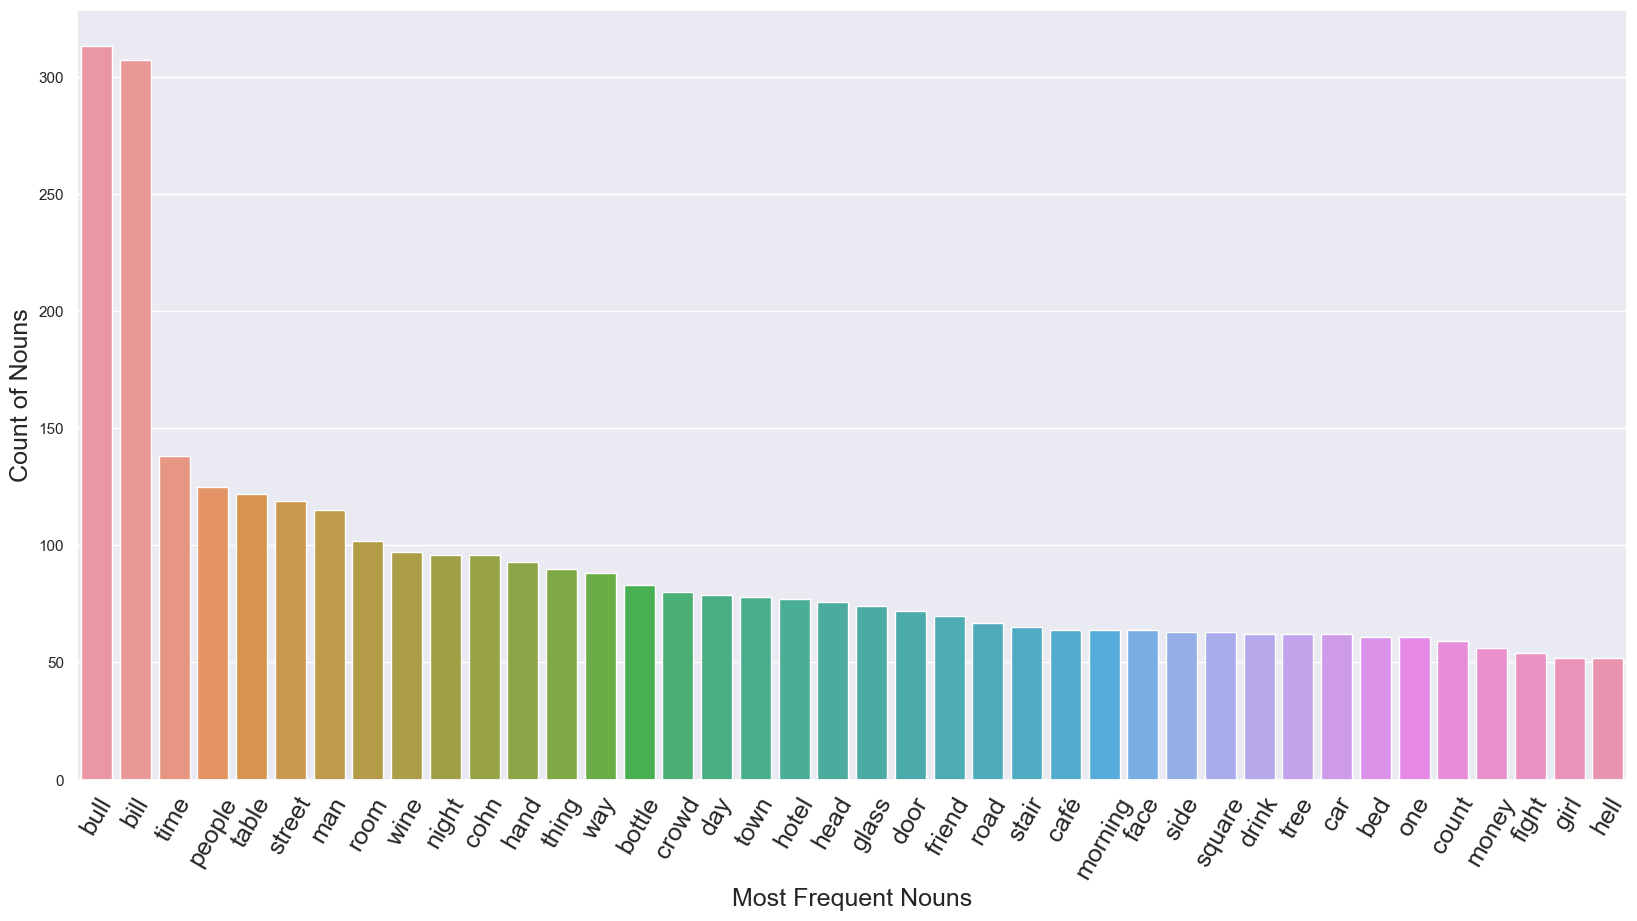

In [226]:
sns.barplot(x="Noun", y='count', data=nouns_df.query('count > 50').sort_values('count', ascending=False))
sns.set(rc = {'figure.figsize':(20,10)})
plt.xlabel('Most Frequent Nouns', fontsize=18)
plt.ylabel('Count of Nouns', fontsize=18)
plt.xticks(rotation = 60, fontsize=18)
plt.savefig('Count for Frequent Nouns')
plt.show()

### This one is really telling

In [230]:
#verbs_df.rename(columns={'VERB':'count', 'index':'Verb'}, inplace=True)
#verbs_df.head()
#verbs_df.drop([141], inplace=True) ## The apostrophe
verbs_df.sort_values('count',ascending=False).head(20)
### Here the apostophe is considered a verb. Cute. I am sure it would be proud. But let's drop it.

,Verb,count
97,say,1104
39,go,769
44,have,430
16,come,410
37,get,400
69,look,295
98,see,288
56,know,264
132,want,220
23,do,194


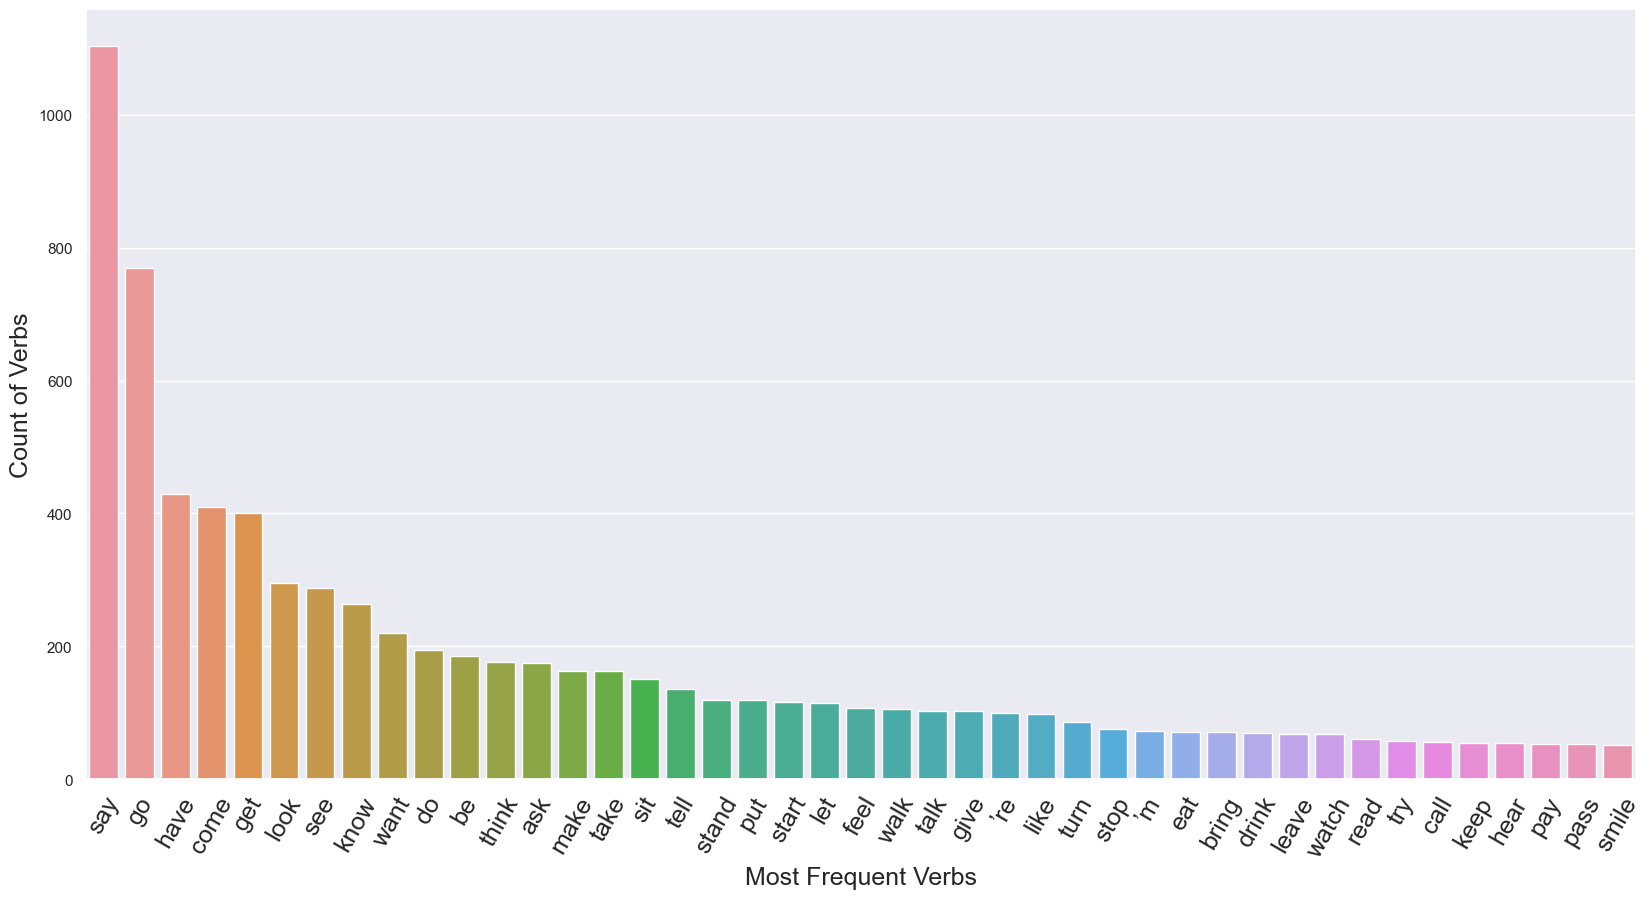

In [227]:
sns.barplot(x="Verb", y='count', data=verbs_df.query('count > 50').sort_values('count', ascending=False))
sns.set(rc = {'figure.figsize':(20,10)})
plt.xlabel('Most Frequent Verbs', fontsize=18)
plt.ylabel('Count of Verbs', fontsize=18)
plt.xticks(rotation = 60, fontsize=18)
plt.savefig('Count for Frequent Verbs')
plt.show()
### This one is really telling too; so many Old English verbs

[Back to the TOC](#id0)

<a id="id6"></a>
## Sentence Frequency by Word Count

Hemingway is known for a sparse, direct style. Clearly his nouns, verbs, and adjectives support that view considering the high rate of Old English vocabulary in his writing. Does the length of his sentences also create this writing style?

In [233]:
### from https://spacy.io/usage/linguistic-features#sbd
assert SAR.has_annotation("SENT_START")
sentences = []
for sent in SAR.sents:
    sentences.append(sent.text)

In [256]:
len(sentences)

5770

In [302]:
sent_df = pd.DataFrame(sentences)
sent_df.rename(columns={0:'sentence'}, inplace=True)
sent_df.head(10)

,sentence
0,”you are all a lost generation.”\n\n ...
1,. .
2,"the sun also ariseth, and the\n sun goeth d..."
3,\n
4,"the wind goeth toward the south, and turneth a..."
5,returneth\n again according to his circuits. .
6,. .
7,all the rivers run into\n the sea; yet the ...
8,\n\n ...
9,do not\nthink that i am very much impressed by...


In [303]:

sent_df['word count'] = sent_df['sentence'].apply(lambda x: len(x.split(' ')))


In [306]:
### getting rid of the epigraphs for this purpose
#sent_df.drop(index=sent_df.index[:9], axis=0, inplace=True)
#sent_df.reset_index(inplace=True)
#sent_df.drop(columns='index', inplace=True)
sent_df.head(30)

,sentence,word count
0,do not\nthink that i am very much impressed by...,20
1,"he cared nothing for boxing, in fact he dislik...",33
2,there was a certain inner comfort in knowing h...,32
3,he was spider\nkelly’s star pupil.,5
4,spider kelly taught all his young gentlemen to...,24
5,but it seemed to fit cohn.,6
6,he was really\nvery fast.,4
7,he was so good that spider promptly overmatche...,14
8,"this increased cohn’s distaste for\nboxing, bu...",21
9,in his last year at princeton he read\ntoo muc...,14


In [308]:
sent_df.sort_values('word count', ascending = False)

,sentence,word count
2079,i wondered if there was anything else i might\...,182
4939,since then he has killed more than a thousand ...,147
4942,"sometimes he turned to smile that\ntoothed, lo...",102
5012,he hasn’t learned it yet.”\n\n“but i thought h...,98
1771,“you can’t blame him such a hell of a lot.”\n\...,88
...,...,...
1713,“hel-lo!,1
1714,hel-lo!,1
5523,\n\n,1
3321,\n\n,1


In [321]:
sent_mean = np.around(np.mean(sent_df['word count']), decimals=2)
sent_std = np.around(np.std(sent_df['word count']), decimals=2)
sent_range = np.max(sent_df['word count']) - min(sent_df['word count'])
print('The mean word count per sentence is {}, \n the standard deviation is {}, \n and the range is {}'\
      .format(sent_mean, sent_std, sent_range))

The mean word count per sentence is 11.08, 
 the standard deviation is 9.66, 
 and the range is 181


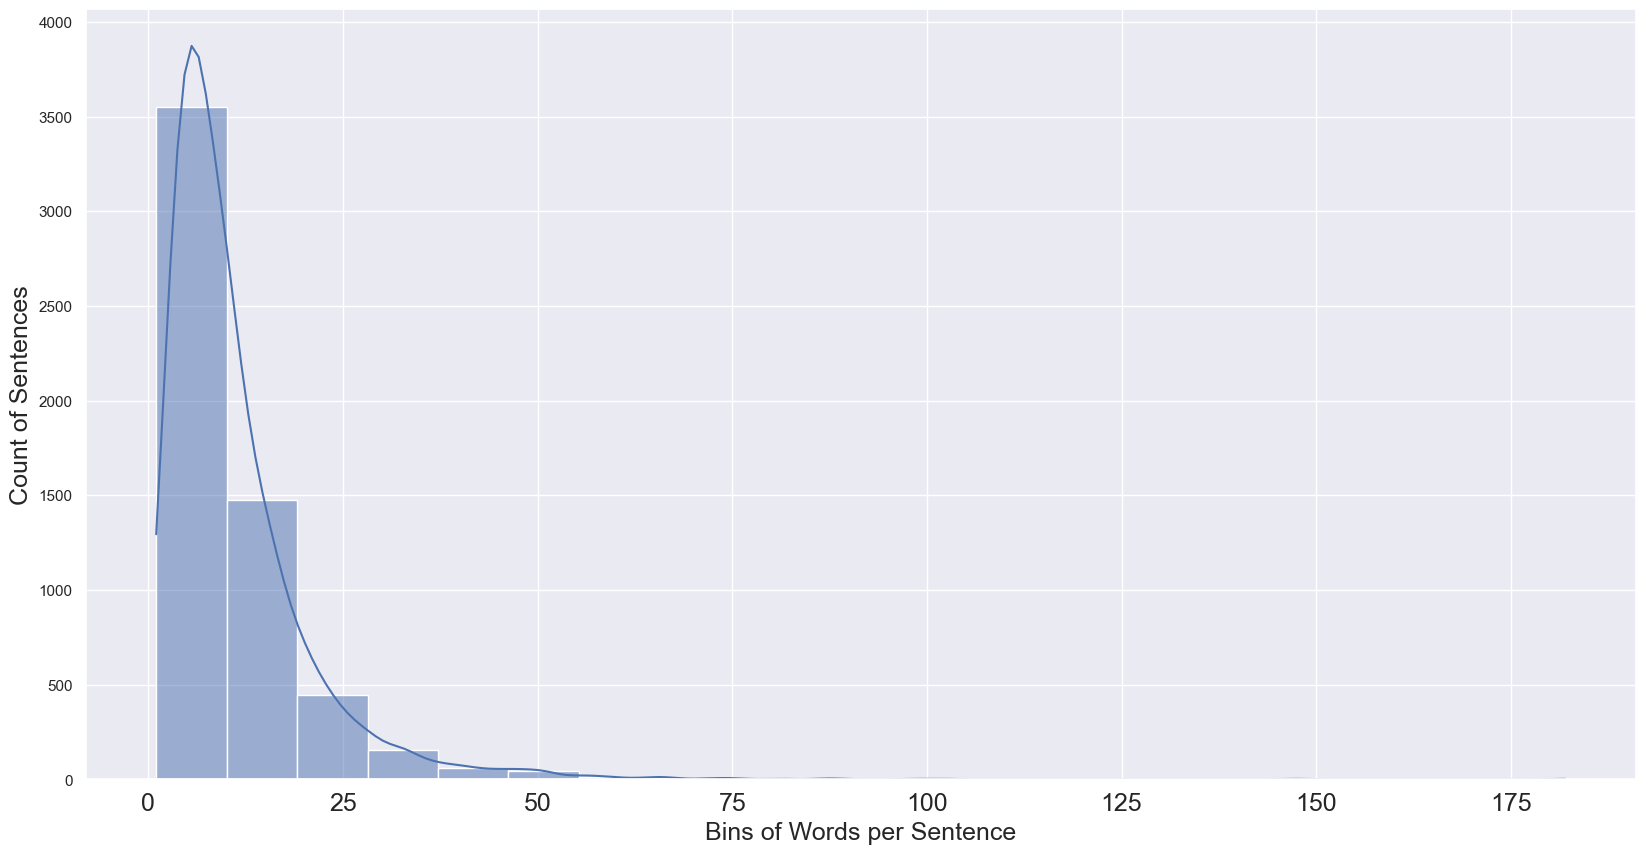

In [343]:
sns.histplot(data=sent_df, x="word count", bins=20, kde=True);
plt.xlabel('Bins of Words per Sentence', fontsize=18)
plt.ylabel('Count of Sentences', fontsize=18)
plt.xticks(rotation = 0, fontsize=18)
plt.savefig('Histogram of word count per sentence')

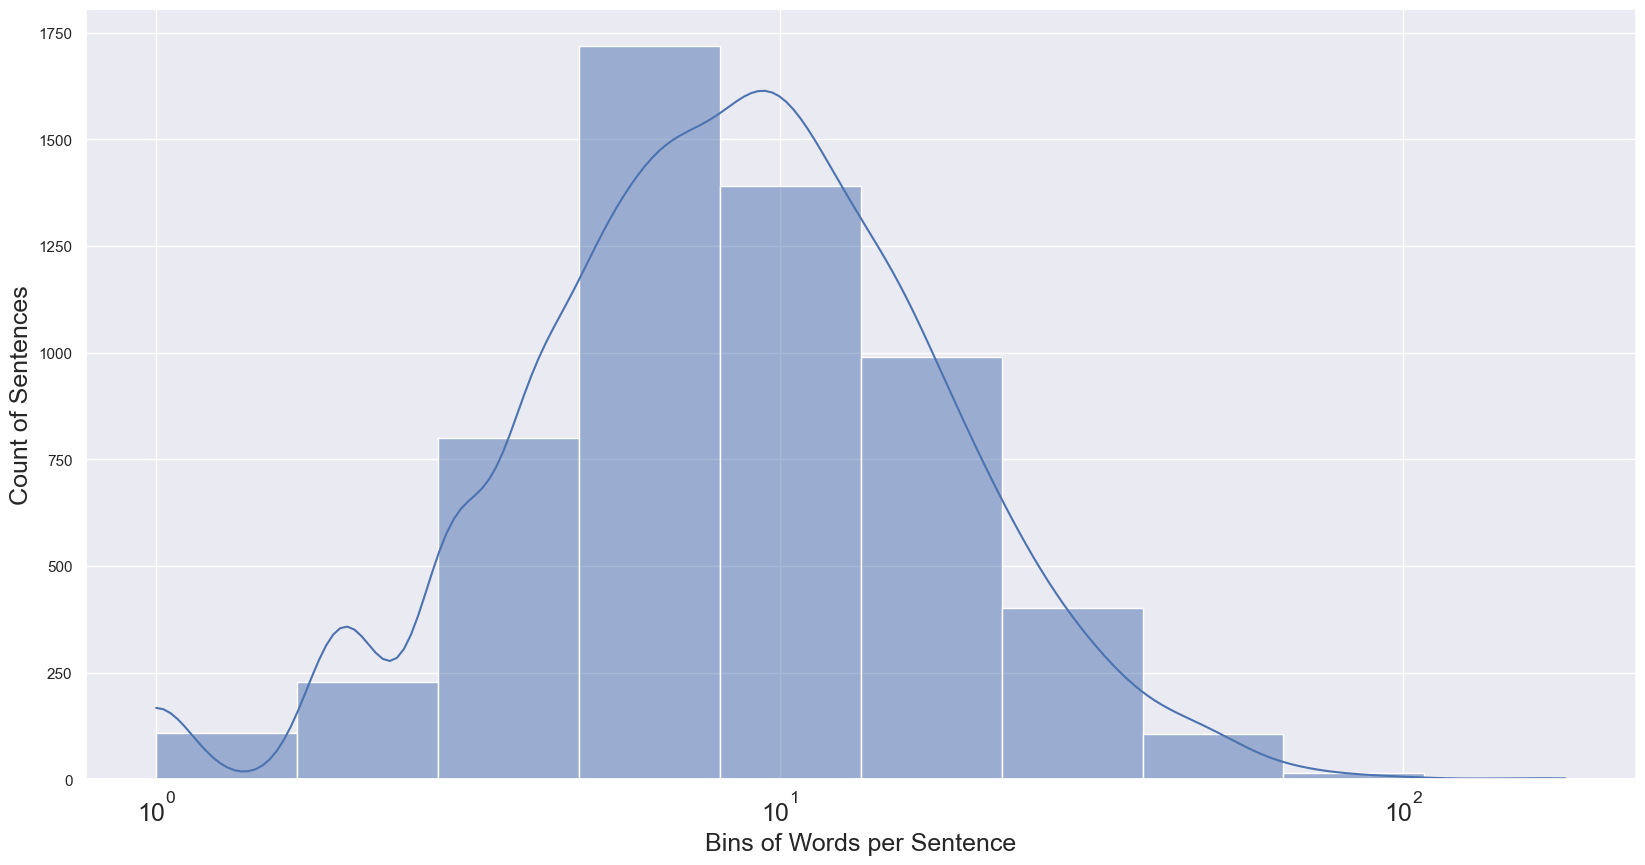

In [344]:
sns.histplot(data=sent_df, x="word count", bins=10, kde=True, log_scale=True);
plt.xlabel('Bins of Words per Sentence', fontsize=18)
plt.ylabel('Count of Sentences', fontsize=18)
plt.xticks(rotation = 0, fontsize=18)
plt.savefig('Histogram of log transformed word count per sentence')

[Back to the TOC](#id0)

<a id="id7"></a>
## Ngram Exploration

In [351]:
### Drawn from https://github.com/EricFillion/N-Grams 
def main(doc):
    result = bigrams(doc)

    for element in result:
        for token in element:
            print(token, end=' ')
        print()  # new line

In [355]:
main(SAR)

” you 
you are 
are all 
all a 
a lost 
lost generation 
generation . 
. ” 
” 

                                  


                                  — 
— gertrude 
gertrude stein 
stein _ 
_ in 
in conversation 
conversation _ 
_ 

     


     ” 
” one 
one generation 
generation passeth 
passeth away 
away , 
, and 
and another 
another generation 
generation cometh 
cometh ; 
; but 
but 
     

     the 
the earth 
earth abideth 
abideth forever 
forever . 
. . 
. . 
. . 
. the 
the sun 
sun also 
also ariseth 
ariseth , 
, and 
and the 
the 
     

     sun 
sun goeth 
goeth down 
down , 
, and 
and hasteth 
hasteth to 
to the 
the place 
place where 
where he 
he arose 
arose . 
. . 
. . 
. . 
. 
     

     the 
the wind 
wind goeth 
goeth toward 
toward the 
the south 
south , 
, and 
and turneth 
turneth about 
about unto 
unto the 
the 
     

     north 
north ; 
; it 
it whirleth 
whirleth about 
about continually 
continually , 
, and 
and the 
the wind 
wind returneth 
r

pressing 
 

 against 
against us 
us when 
when other 
other people 
people crowded 
crowded them 
them . 
. 

 


 “ 
“ why 
why do 
do n’t 
n’t they 
they start 
start ? 
? ” 
” robert 
robert cohn 
cohn asked 
asked . 
. 

 


 a 
a single 
single mule 
mule was 
was hitched 
hitched to 
to one 
one of 
of the 
the cages 
cages and 
and dragged 
dragged it 
it up 
up against 
against 
 

 the 
the gate 
gate in 
in the 
the corral 
corral wall 
wall . 
. the 
the men 
men shoved 
shoved and 
and lifted 
lifted it 
it with 
with crowbars 
crowbars 
 

 into 
into position 
position against 
against the 
the gate 
gate . 
. men 
men were 
were standing 
standing on 
on the 
the wall 
wall ready 
ready to 
to 
 

 pull 
pull up 
up the 
the gate 
gate of 
of the 
the corral 
corral and 
and then 
then the 
the gate 
gate of 
of the 
the cage 
cage . 
. at 
at the 
the 
 

 other 
other end 
end of 
of the 
the corral 
corral a 
a gate 
gate opened 
opened and 
and two 
two steers 
ste

In [360]:
def bigram(doc):
    # create a list for the result
    result2 = list()
    # create a list that contains no punctuation
    sentence2 = list()
    # parse through the document to add all tokens that are words to the sentence list
    for token in doc:
        if token.is_alpha:
            sentence2.append(token)
    # parse through the sentence while adding words in groups of two to the result
    for word in range(len(sentence2) - 1):
        first_word = sentence2[word]
        second_word = sentence2[word + 1]
        element2 = [first_word.text, second_word.text]
        result2.append(element2)

    return result2

In [368]:
bi = bigram(SAR)

In [366]:
def trigram(doc):
    # create a list for the result
    result3 = list()
    # create a list that contains no punctuation
    sentence3 = list()
    # parse through the document to add all tokens that are words to the sentence list
    for token in doc:
        if token.is_alpha:
            sentence3.append(token)
    # parse through the sentence while adding words in groups of two to the result
    for word in range(len(sentence3) - 2):
        first_word = sentence3[word]
        second_word = sentence3[word + 1]
        third_word = sentence3[word + 2]
        element3 = [first_word.text, second_word.text, third_word.text]
        result3.append(element3)

    return result3

In [371]:
tri = trigram(SAR)

In [372]:
bigram_df=pd.DataFrame(bi, columns=('first_word', 'second_word'))
trigram_df=pd.DataFrame(tri, columns=('first_word', 'second_word', 'third_word'))


In [373]:
bigram_df.head()

,first_word,second_word
0,you,are
1,are,all
2,all,a
3,a,lost
4,lost,generation


In [374]:
trigram_df.head()

,first_word,second_word,third_word
0,you,are,all
1,are,all,a
2,all,a,lost
3,a,lost,generation
4,lost,generation,gertrude


In [391]:
###may ditch the earlier ngramm work for nltk's packages; 
### will need to work from the text itself and not SAR
### drawing from https://www.kaggle.com/code/rtatman/tutorial-getting-n-grams
punctuationNoPeriod = "["+ re.sub("\.",",'”','—',''',", string.punctuation) +"]"
text2 = re.sub(punctuationNoPeriod, "", text)
bi_nltk = ngrams(text2, 2)

In [392]:
text2[0:2000]

'you are all a lost generation.\n\n                                 gertrude stein in conversation\n\n    one generation passeth away and another generation cometh but\n    the earth abideth forever. . . . the sun also ariseth and the\n    sun goeth down and hasteth to the place where he arose. . . .\n    the wind goeth toward the south and turneth about unto the\n    north it whirleth about continually and the wind returneth\n    again according to his circuits. . . . all the rivers run into\n    the sea yet the sea is not full unto the place from whence the\n    rivers come thither they return again.\n\n                                                   ecclesiastes\n\n\n\n\n                                 book i\n\n\n\n\n                                chapter\n                                   1\n\n\nrobert cohn was once middleweight boxing champion of princeton. do not\nthink that i am very much impressed by that as a boxing title but it\nmeant a lot to cohn. he cared nothing fo

In [393]:
bigram_count = NgramCounter(bi_nltk)

TypeError: Ngram <y> isn't a tuple, but <class 'str'>

In [398]:
###Combo approach failed for ngrams so trying a unified nltk approach.
text_bigrams = [ngrams(sent, 2) for sent in text2]
text_unigrams = [ngrams(sent, 1) for sent in text2]

In [399]:
ngram_counts = NgramCounter(text_bigrams + text_unigrams)

In [402]:
ngram_counts.N()


356256

In [404]:
nltk.download('punkt')
tokens = nltk.word_tokenize(text2)

[nltk_data] Downloading package punkt to /Users/kirk/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [436]:
bigrams = nltk.bigrams(tokens)

In [437]:
frequency = nltk.FreqDist(bigrams)

bigram_list = lambda key,value: for key, value in frequency.items()

    

SyntaxError: invalid syntax (2838827479.py, line 3)

(<function <lambda> at 0x7f8a23bbb160>, False)


In [426]:
bigram_df = pd.DataFrame(frequency)

ValueError: If using all scalar values, you must pass an index

In [421]:
bigram_df.head()

""


In [453]:
### Remove stop words from text2

In [447]:
### Starting fresh here: Drawing from https://www.kaggle.com/code/scratchpad/notebookdbaabe5532/
# Function n_gram: splits the words in order to given parameter
# Parameter n: it's the "n" number for "n-gram"
def n_gram(n):                                             
    n_grams = ngrams(text2.split(), n)
    return n_grams

In [448]:
sentences = []
df_frequency = []

In [449]:
# Function frequency: counts the frequency of the each "n-gram" output
# Parameter grammed: it takes the function "n_gram"s return as value. Briefly, the grammed text.
def frequency(grammed):
    sentences.clear()
    df_frequency.clear()
    freq = nltk.FreqDist(grammed)
    for k, v in freq.items():
        sentences.append(k)                     # Sentences is a list, stores the grams(ignores duplicates)
        df_frequency.append(v)                  # df_frequency is a list, stores the frequency of grams
        

In [450]:
# Function create_plot: it creates a plot for given grams
# Parameter num: it's a number to send it to "n_gram" function
def create_plot(num):
    frequency(n_gram(num)) # Send "num" parameter to "n_gram func." and send the result to "frequency func."

    gram_frame = pd.DataFrame(sentences)       # gram_frame is the data frame to store grams and freq.

    gram_frame['frequencies'] = df_frequency
    if num == 2:
        gram_frame.columns = ['first', 'second', 'frequencies']
    if num == 3:
        gram_frame.columns = ['first', 'second', 'third', 'frequencies']

    gram_frame.sort_values("frequencies", axis=0, ascending=False, inplace=True, na_position='last')

    gram_frame = gram_frame.head(20)            # Only take the top 20 of gram_frame

    total = sum(df_frequency)

    gram_frame["ratio"] = gram_frame['frequencies'].div(total)   # Additional, ratio is added

    plt.rcdefaults()
    fig, ax = plt.subplots()

    if num == 2:
        grams = gram_frame["first"] + " " + gram_frame["second"]
    if num == 3:
        grams = gram_frame["first"] + " " + gram_frame["second"] + " " + gram_frame["third"]

    # Create plot
    y_pos = np.arange(len(grams))
    performance = gram_frame["frequencies"]

    ax.barh(y_pos, performance)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(grams)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Frequency')
    ax.set_title('2-3 grams')

    plt.show()
    display(gram_frame)

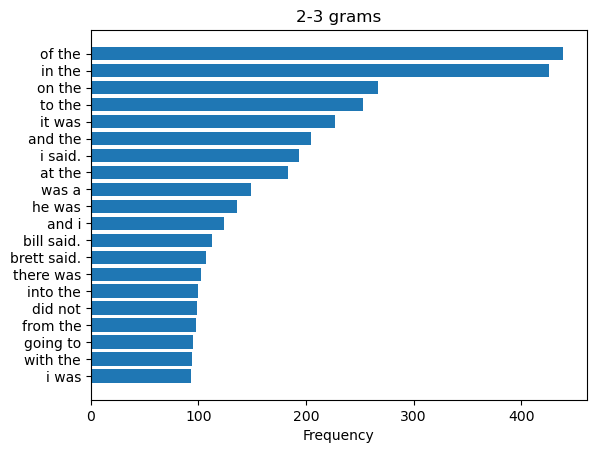

,first,second,frequencies,ratio
381,of,the,439,0.006474
188,in,the,426,0.006283
407,on,the,267,0.003938
35,to,the,253,0.003731
625,it,was,227,0.003348
29,and,the,205,0.003023
989,i,said.,193,0.002846
393,at,the,183,0.002699
158,was,a,149,0.002197
191,he,was,136,0.002006


In [451]:
create_plot(2)   # Create plot for bigram 

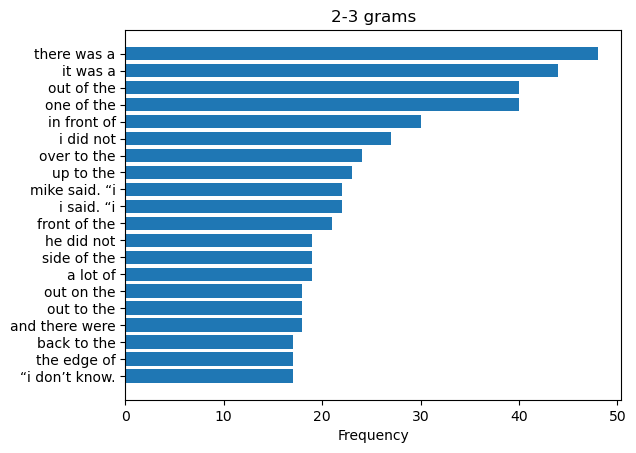

,first,second,third,frequencies,ratio
168,there,was,a,48,0.000708
1000,it,was,a,44,0.000649
3289,out,of,the,40,0.000590
414,one,of,the,40,0.000590
4374,in,front,of,30,0.000442
1860,i,did,not,27,0.000398
4327,over,to,the,24,0.000354
1374,up,to,the,23,0.000339
18124,mike,said.,“i,22,0.000324
4803,i,said.,“i,22,0.000324


In [452]:
create_plot(3)   # Create plot for trigram